In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
exp=np.genfromtxt("expdata.txt", delimiter='\t')
amp0=np.genfromtxt("amp0.txt", delimiter='\t')
OD=np.genfromtxt("OD.txt", delimiter='\t')
constants_prob=np.genfromtxt("constants.txt", delimiter='\t')
iptg=exp[:,0][:,None]
tet0=exp[:,1][:,None]
MIC_exp=exp[:,2][:,None]
IND_exp=exp[:,3][:,None]
amp0=np.sort(amp0)[:,None]

In [3]:
deg_mult=np.array([5000,1000])
def bandpass(constants_prob,deg_mult,iptg,tet0,amp0):
    bg_bla=constants_prob[0]*deg_mult[0]     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*50         #0.01 #uM combo of laci/kd_laci
    #kd_laci=constants_prob[2]*5e-3   #7.8e-4 #uM
    n_laci=constants_prob[2]*5        #2.5
    kd_iptg=constants_prob[3]*50      #25 #uM
    n_iptg=constants_prob[4]*5        #2
    #kcat=constants_prob[6]*5e6       #2.82e5 #1/m
    km=constants_prob[5]*500          #100 #uM
    ktr=constants_prob[6]*1e-2        #1e3 Combo of ktr and kcat
    MIC_int=constants_prob[7]*5       #amp[0,5]
    bg_tetc=constants_prob[8]*deg_mult[1]    #10/0.1 #uM/min combo of beta and gamma
    ampr=constants_prob[9]*100        #0.1/1e-2 #uM combo of ampr/kd_ampr
    n_ampr=constants_prob[10]*5       #1
    kd_amp=constants_prob[11]*0.5      #0.5 #uM
    n_amp=constants_prob[12]*5        #1
    k_tet=constants_prob[13]*10     #10
    MIC_tet_int=constants_prob[14]*5  #2
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<=amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]


    MIC_mod=np.zeros(len(iptg))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if amp[i,j]>=MIC_int:
                break
            MIC_mod[i]=amp0[j]

            
    tetc=np.zeros((len(iptg),len(amp0)))
    tet=np.zeros((len(iptg),len(amp0)))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            D_amp=1+(amp[i,j]/kd_amp)**n_amp
            D_ampr=1+(ampr/(D_amp))**n_ampr
            tetc[i,j]=bg_tetc/D_ampr
            tet[i,j]=tet0[i]*k_tet/(k_tet+tetc[i,j])

    #tet=tet0*k_tet_dif/(k_tet_dif+k_tet_act*tetc)
    MIC_tet_mod=np.zeros(len(iptg))[:,None]
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if tet[i,j]<=MIC_tet_int:
                break
            MIC_tet_mod[i]=amp0[j]
            
    modeloutput=np.zeros((len(iptg),2))
    for i in range(len(iptg)):
        modeloutput[i,0]=MIC_mod[i]
        modeloutput[i,1]=MIC_tet_mod[i]
    return modeloutput

In [ ]:
high_mod=np.zeros((constants_prob.shape[0],iptg.shape[0]))
low_mod=np.zeros((constants_prob.shape[0],iptg.shape[0]))
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],deg_mult,iptg,tet0,amp0)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]

out=np.hstack((iptg,tet0,MIC_exp,high_mod.mean(axis=0)[:,None],IND_exp,low_mod.mean(axis=0)[:,None]))
pd.DataFrame(out,columns=['IPTG','Tet','Highpass(Exp)','Highpass(Model)','Lowpass(Exp)','Lowpass(Model)'])

In [11]:
iptg_set=np.array([270])
tet0_set=np.array([18])
high_mod=np.zeros((constants_prob.shape[0],iptg_set.shape[0]))
low_mod=np.zeros((constants_prob.shape[0],iptg_set.shape[0]))
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],deg_mult,iptg_set,tet0_set,amp0)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]

In [21]:
deg_mult_prob =pm.Uniform('deg_mult_prob', 0.000000000001, 10000.0,size=2)
rand_select=np.random.randint(320, size=10)
constants_subset=constants_prob[rand_select,:]
@pm.deterministic
def constrictor(deg_mult_prob=deg_mult_prob,constants_subset=constants_subset,iptg_set=iptg_set,tet0_set=tet0_set,amp0=amp0):
    modeloutput=np.zeros((constants_subset.shape[0],2))
    for i in range(constants_subset.shape[0]):
        modeloutput[i,:]=bandpass(constants_subset[i],deg_mult_prob,iptg_set,tet0_set,amp0)
    return modeloutput

In [22]:
#goal set
goal=np.zeros((10,2))
for i in range(10):
    goal[i,:]=np.array([112.5,14.063])

goal_prob = pm.Normal('goal_prob', mu=constrictor,tau=1000,value=goal, observed=True)

In [23]:
model = pm.Model([deg_mult_prob,constrictor,goal_prob])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(20000, burn=4000, thin=50)

 [-----------------100%-----------------] 20000 of 20000 complete in 126.0 sec

In [24]:
deg_samples=mcmc.trace('deg_mult_prob')[:]
constrictor_samples=mcmc.trace('constrictor')[:]

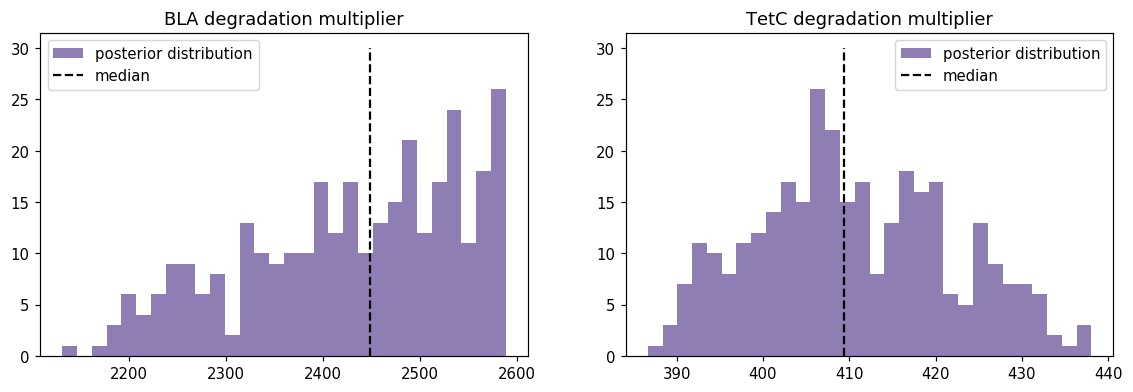

In [34]:
fig = plt.figure(figsize=(8*1.618, 4), dpi=107)

ax1 = fig.add_subplot(121)
i=0
plt.hist(deg_samples[:,i], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior distribution", color="#7A68A6");
plt.vlines(np.median(deg_samples[:,i]), 0, 30, linestyle="--", label="median")
plt.legend(loc="upper left")
plt.title("BLA degradation multiplier")
np.median(deg_samples[:,i])
ax2 = fig.add_subplot(122)
i=1
plt.hist(deg_samples[:,i], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior distribution", color="#7A68A6");
plt.vlines(np.median(deg_samples[:,i]), 0, 30, linestyle="--", label="median")
plt.legend(loc="upper right")
plt.title("TetC degradation multiplier")
np.median(deg_samples[:,i])
plt.savefig('mult_dist.png',bbox_inches="tight")

In [28]:
constrictor_samples.shape

(320, 10, 2)

In [35]:
deg_mult_con=np.array([np.median(deg_samples[:,0]),np.median(deg_samples[:,1])])
iptg_set=np.array([270])
tet0_set=np.array([18])
high_mod=np.zeros((constants_prob.shape[0],iptg_set.shape[0]))
low_mod=np.zeros((constants_prob.shape[0],iptg_set.shape[0]))
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],deg_mult_con,iptg_set,tet0_set,amp0)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]

In [46]:
high=np.zeros(amp0.shape)
low=np.zeros(amp0.shape)
for i in range(amp0.shape[0]):
    p_high=high_mod<=amp0[i]
    p_low=low_mod<=amp0[i]
    high[i]=sum(p_high)/320
    low[i]=sum(p_low)/320

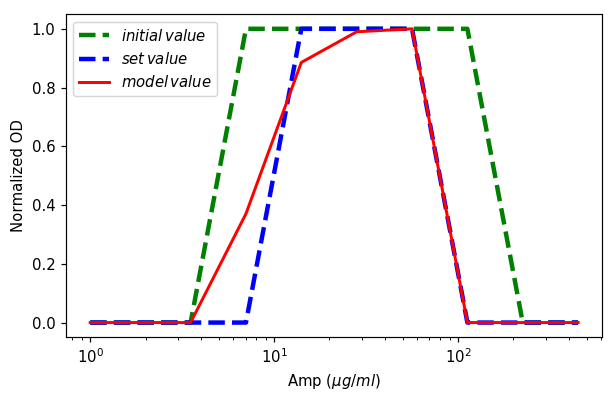

In [70]:
OD_predict=(1-high)*low
OD_predict=(OD_predict-min(OD_predict))/(max(OD_predict)-min(OD_predict))
amp0[0]=1
OD_set=np.array([0,0,0,0,1,1,1,0,0,0])
OD_ini=np.array([0,0,0,1,1,1,1,1,0,0])
fig = plt.figure(figsize=(4*1.618, 4), dpi=107)
plt.semilogx(amp0,OD_ini,'g--',linewidth=3.0, label='$ initial \, value $')
plt.semilogx(amp0,OD_set,'b--',linewidth=3.0, label='$ set \, value $')
plt.semilogx(amp0,OD_predict,'r-',linewidth=2.0, label='$ model \, value $')
plt.xlabel('Amp $(\mu g/ml)$')
plt.ylabel('Normalized OD')
plt.legend(loc='upper left')
plt.savefig('norm_OD_con.png',bbox_inches="tight")